In this notebook, we'll try analyzing Sylas's data of beads in networks using methods described in this [Cho et al 2020 PRL paper](https://link.aps.org/doi/10.1103/PhysRevLett.124.088005).

With DDM, we take a movie and generate the DDM matrix, $D(q,\Delta t)$ (the generation of this DDM matrix should already have been done before going through this code). This can be fit to the function:
$D(q,\Delta t) = A(q)(1 - f(q,\Delta t)) + B(q)$. 
The function $f(q,\Delta t)$ is called the intermediate scattering function (ISF). And we usually assume it has the form: $f(q,\Delta t) = \mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)}$ where $\alpha (q)$ is the stretching exponent and $\tau (q)$ is the characteristic decay time.

What we have usually tried is to take $D(q,\Delta t)$ and, for each wave vector $q$, fit it to find the parameters $A, B, \tau, \text{ and } \alpha$.

What we do now (using the methods of [Cho et al](https://link.aps.org/doi/10.1103/PhysRevLett.124.088005)) is get the parameters $A$ and $B$ from the images themselves. Then we can get the ISF: $f(q,\Delta t) = 1 - \frac{D(q,\Delta t) - B(q)}{A(q)}.$ 

We also add a new paramter to the ISF: the non-ergodicity parameter, $C$. So now we have that the ISF is equal to: $f(q,\Delta t) = (1-C(q))\mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)} + C(q)$. If $C$ is zero, then this ISF is just $\mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)}$, as we had before. And that's the expected case for ergodic dynamics. But if the system is non-ergodic, then we expect a non-zero $C$, somewhere between 0 and 1. 

Note that in this code, we refer to $D(q, \Delta t)$ as 'ravs'. That is because getting $D(q, \Delta t)$ invovles finding the <b>r</b>adial <b>av</b>erages of a matrix.

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from timeit import default_timer as timer

font_plt = {'family': 'serif','color':  'darkred','weight': 'normal','size': 8,}
font_plt_ax = {'family': 'serif','color':  'black','weight': 'normal', 'size': 8,}

import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import os
import csv
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
from scipy.optimize import leastsq
import pickle #for saving data
from importlib import reload

In [4]:
reload(ddm) #reload of ddm necessary if changes have been made

<module 'ddm_clean' from 'Y:\\Pawan K\\DDM\\ddm_clean.py'>

## Movie number and ROI specified below

In [5]:
#######################################################################################
#Specify where the data is stored and the image data filename. Must be in tiff format
#######################################################################################

########################
# Select Movie Number  #
movie_num = 1
########################
date= '2020-11-03'
#######################
condition="Beads_buffer"
glycerol=82
frames=30
#condition="AMT_myosin"
#condition="100M_myosin"
#condition="75A25M"
#condition="25A75M"
########### Select ROI here ###############
ROI = 0  # <---- select ROI (0,256,512, or 768)
###########################################

#data_dir = "Y:\\Jon_Garamella\\data\\active_networks\\videos_date\\%s\\%s\\DDM\\20200914_%iperGlyc_594beads_561OD2_20msEXPO_50fps_%iKFR_%i\\" % (date,condition,glycerol,frames,movie_num)
#data_file = "20200914_%iperGlyc_594beads_561OD2_20msEXPO_50fps_%iKFR_%i_MMStack_Pos0.ome.tif" %(glycerol,frames,movie_num)

## Below, we load in the images. If this step was already done and you can read in the pickle file containing the necessary data, don't bother rerunning this.

In [243]:
#Image read using tiff_file module
#im = ddm.tiff_file.imread(data_dir+data_file)

#Display the second frame of the image
#plt.figure(figsize=(8,3))
#plt.matshow(im[1], cmap=matplotlib.cm.gray, fignum=0)

### Open up the previosly generated DDM matrix data

In [12]:
#######################################################################################
#  Specify where the DDM matrix data is stored
#######################################################################################
movie_num = 1
ROI = 0
data_dir = "Y:\\Pawan K\\2021_DATA\DDM_and_PT_Olympus_2021_Jan_5\\1\\"
rav_file = "%s_%s_256x256_FFTDIFFS_dts_ravs.p" %(movie_num, ROI)



f = open(data_dir + rav_file,'rb')
rav_data = pickle.load(f)
f.close()
#copy over that data stored in the dictionary
ravs = rav_data['ravs']
dts = rav_data['dts']
print("The 'keys' contained in this pickle'd dictionary are: ", rav_data.keys())

#Copy over the Amplitude and Background data generated previously

data_file = rav_file[:-19]+"rav_imageffts_for_AB.p"
f = open(data_dir + data_file,'rb')
p_data = pickle.load(f)
f.close()
rad_av_av_fftsq = p_data['rad_av_av_fftsq']

The 'keys' contained in this pickle'd dictionary are:  dict_keys(['dts', 'ffts', 'ravs'])


In [13]:
#copy over that data stored in the dictionary
ravs = rav_data['ravs']
dts = rav_data['dts']

In [14]:
##########################################################################
# Specify the frame rate (fps) and pixel size
##########################################################################

fps = 20. #The frame rate the video data was recorded at. 
times = dts/fps #Create the list of delay times in units of seconds
pixel_size = 0.1884 #pixel size in microns
numPixels = 256. #number pof pixels in ROI
q = np.arange(0.,numPixels/2.)*2.*np.pi*(1./(numPixels*pixel_size)) #Convert the spatial frequencies to wave vectors

In [15]:
q[10]

1.302743768905003

<IPython.core.display.Javascript object>


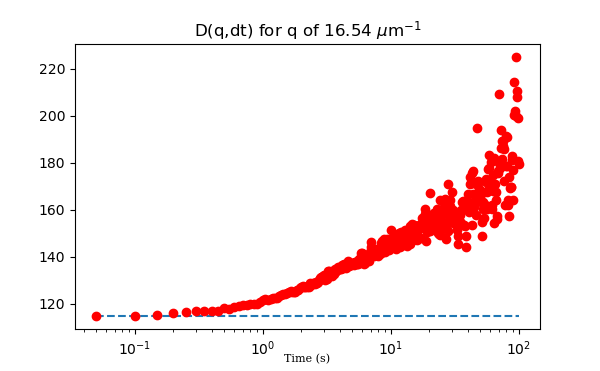

Horizontal line at 114.6


In [16]:
# Here, we'll show the image structure function for a particular q-value. 

qv=-1 # <-- this is the last q-value. useful for getting estimate of background
fig = plt.figure(figsize=(6,6./1.618))
plt.semilogx(times, ravs[:,qv],'ro')
ax = plt.gca()
plt.xlabel('Time (s)', fontdict=font_plt_ax, labelpad=-3);
plt.title("D(q,dt) for q of %.2f $\mu$m$^{-1}$" % q[qv]);
plt.hlines(ravs[0,qv], times[0], times[-1], linestyles='dashed')
print("Horizontal line at %.1f" % ravs[0,qv])

At this step, we could try fitting $D(q, \Delta t)$ to the model described at the very beginning to determine $A$, $B$, $\tau$ and $\alpha$. If you want to do that, you'll find the code at the end of this notebook. But that step isn't necessary.

<IPython.core.display.Javascript object>


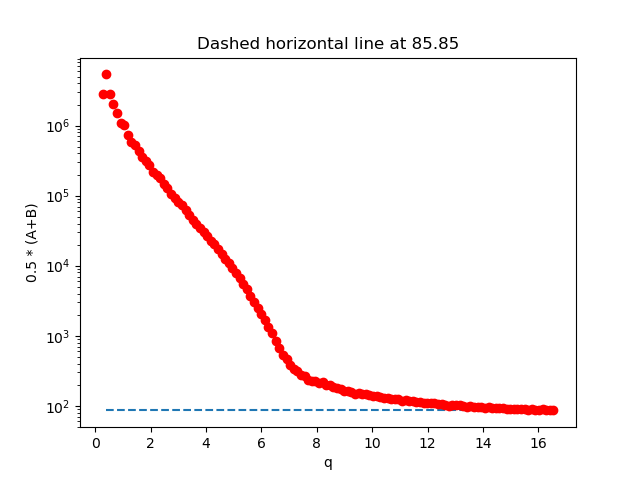

Text(0.5, 1.0, 'Dashed horizontal line at 85.85')

In [18]:
plt.figure()
plt.semilogy(q[2:], rad_av_av_fftsq[0,2:],'ro')
plt.xlabel("q")
plt.ylabel("0.5 * (A+B)")
plt.hlines(rad_av_av_fftsq[0,-1], q[3], q[-1], linestyles='dashed')
plt.title("Dashed horizontal line at %.2f" % rad_av_av_fftsq[0,-1])

Based off of the DDM data, I'd say the background is ~ 40 (in many cases, depends on video). 
Based off the above plot, seems like it (1/2)(A+B) is plateauing at high q to around ??. So B is around twice that. 

In [19]:
############################################################
#You can play around with this 'background' parameter
############################################################
background = ravs[0,-1]*.9
new_amplitude = (2*rad_av_av_fftsq[0]) - background

<IPython.core.display.Javascript object>


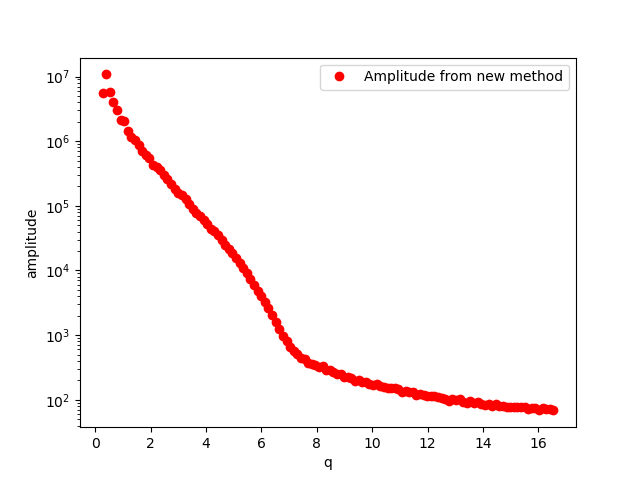

'amp' not defined


In [21]:
plt.figure()
plt.semilogy(q[2:], new_amplitude[2:], 'ro', label='Amplitude from new method')
try: plt.plot(q[3:], amp[2:], 'mo', label='Amplitude from fitting method')
except: print("'amp' not defined")
plt.xlabel("q")
plt.ylabel("amplitude")
plt.legend(loc=0)

Based on our new value for amplitude, let's find the intermediate scattering function

In [22]:
#Just double checking sizes of arrays:
print("size of ravs array (the ddm matrix or image struct func): %i by %i" % ravs.shape)
print("size of new amplitudes: %i" % new_amplitude.shape)

size of ravs array (the ddm matrix or image struct func): 400 by 128
size of new amplitudes: 128


In [23]:
#Initialize arrays to store the ISF (intermediate scattering function)
isf = np.zeros_like(ravs) #decay time
msd = np.zeros_like(ravs)

for i in range(1,ravs.shape[1]):
    isf[:,i] = 1 - ((ravs[:,i] - background) / new_amplitude[i])
    msd[:,i] = (-4.0 / ((q[i])**2.0))*np.log(1 - ((ravs[:,i] - background) / new_amplitude[i]))

<ipython-input-23-89747c1fa71b>:7: RuntimeWarning: invalid value encountered in log
  msd[:,i] = (-4.0 / ((q[i])**2.0))*np.log(1 - ((ravs[:,i] - background) / new_amplitude[i]))


<IPython.core.display.Javascript object>


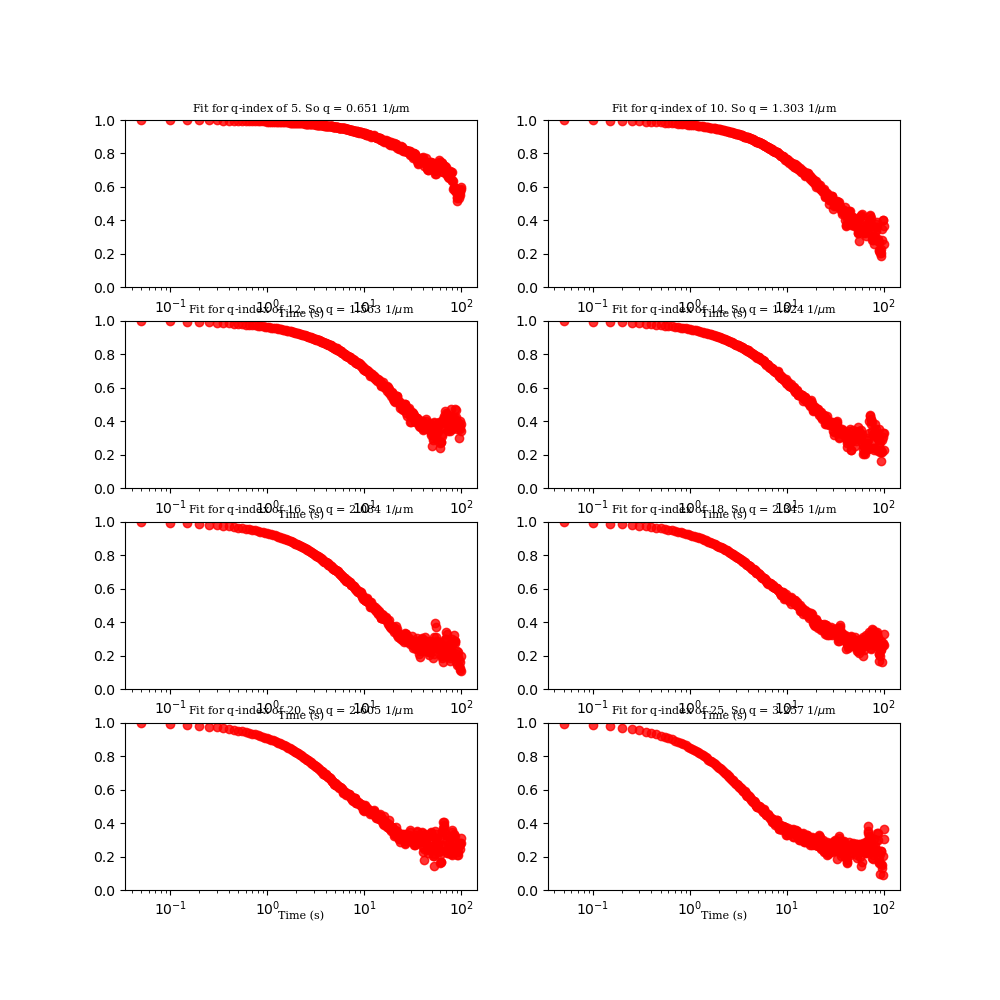

In [24]:
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)


#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([5,10,12,14,16,18,20,25]):

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,isf[:,q_index],'ro',alpha=0.8)
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax, labelpad=-5)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    
    ax.set_ylim(0,1)

### Defining the fitting function

The fitting function, `isf_fitting`, is described below. After running through this cell (and the next 3 or 4), you'll need to come back to this point and re-run this function after you settle on a stretching exponent to use. You'll come back to the first uncommented-out line: <br>
`STRETCHING_EXP = 0.6` <br>
and set the value (which is the stretching exponent, $\alpha (q)$) to the correct value. 

In [56]:
data_file[:-18]

'1_0_256x256_rav_'

<IPython.core.display.Javascript object>


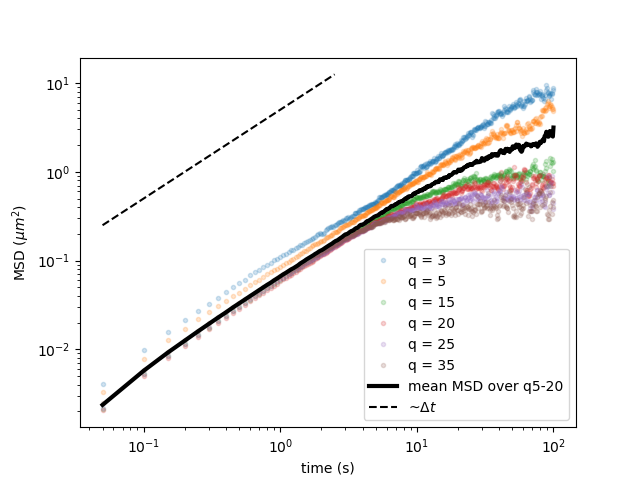

In [64]:
plt.figure()
#col=["b",'g','r','c','m','y']
q_loop=[3,5,15,20,25,35]
#col=np.linspace(0.1,1,len(q_loop))
for i,qi in enumerate(q_loop):
    plt.loglog(times,msd[:,qi], ".", label="q = %i"%q_loop[i], alpha=0.2)

msd_ave=np.zeros(len(times))
for i in range(len(msd[:,0])):
    qmin=5
    qmax=20
    msd_ave[i]=np.nanmean(msd[i,qmin:qmax])
    
plt.plot(times[:1000],msd_ave[:1000],'-k', lw=3., label="mean MSD over q%i-%i"%(qmin,qmax))
plt.plot(times[:50], 5*times[:50],'--k', label="~$\Delta t$")
plt.xlabel("time (s)")
plt.ylabel("MSD ($\mu$$m^{2}$)")
plt.legend() 
#np.savetxt(data_dir+data_file[:-18]+"MSD_q%i-%i.csv"%(qmin,qmax), msd_ave, delimiter=',')
#np.savetxt(data_dir+data_file[:-18]+"times.csv", times, delimiter=',')
np.savetxt(data_dir+data_file [:-18]+ "MSD_times_q%i-%i.csv"%(qmin,qmax),np.c_[msd_ave, times],delimiter = ',',header = "MSD,times")

In [27]:
##################################################################################################
# Stretching exponent.
# This number must be between 0 and 1. 
# And it will probably be around 0.6.
# When you specify the value, don't go beyond hundredths place.
# Set this to the AVERAGE VALUE you found when this parameter was allowed to vary.
##################################################################################################
STRETCHING_EXP =0.35  # <----- THIS NUMBER NEEDS TO CHANGE AFTER GOING THROUGH NEXT COUPLE STEPS!

##################################################################################################
# Fix stretching exponent... it may help to fix
# Set this to true or false. 
# 
# BUT WE'LL SET THIS PARAMETER'S VALUE (TRUE or FALSE) ELSEWHERE
# So leave this commented out for now
#  
##################################################################################################
#FIX_STRETCHING_EXP = False #False will allow stretching exponent to vary. True will hold constant

def errorfunc_for_scipy_leastsq_fit(params, data, times):
    theory = ddm.dTheoryNonErgISF(times, params[0],params[1],params[2])
    return data-theory

def isf_fitting(data, times):
    '''
    This function does the ISF fitting. 

    We'll just use one round. Using Levenberg-Marquardt method with the mpfit module. 
    '''
    
    #Our parameters are: c (non-ergodicity param), tau, stretching epxonent
    pars = np.zeros(3)*1.0
    minp = np.zeros_like(pars)
    maxp = np.zeros_like(pars)
    lmin = np.array([True, True, True])
    lmax = np.array([True, True, True])
    fix = np.array([False, False, False])
    
    #come up with limits:
    minp[0] = 0.0 #minimum non-erg parameter
    maxp[0] = 1.0 #maximum non-erg parameter
    minp[1] = 0.01 #minimum decay time
    maxp[1] = 3000.0  #maximum decay time
    minp[2] = 0.1 #minimum stretching exponent
    maxp[2] = 1.1 #maximum stretching exponent
    
    #initial guesses 
    pars[0] = 1.0 #non-ergodicity parameter
    pars[1] = 50.0 #decay time
    ############################################################################
    # Below (pars[2]) is the stretching exponent. 
    # After letting it vary, set to average value and
    # fix it at that.
    #
    # YOU MUST CHANGE THIS TO AVERAGE VALUE OVER REASONALBE RANGE OF Q
    ###########################################################################
    pars[2] = STRETCHING_EXP #stretching exponent. 
    
    fix[2] = FIX_STRETCHING_EXP   #True or False -- set above
    
    # First step, use the Scipy Least Squares function to find best parameters
    #   We will then use those parameters as initial guess in the Levenberg-Marquardt method
    fitparams_lstsq_temp = leastsq(errorfunc_for_scipy_leastsq_fit, pars, args=(data,times))
    fitparams_isf_lstsq = fitparams_lstsq_temp[0]
    theory_isf_lstsq = ddm.dTheoryNonErgISF(times, fitparams_isf_lstsq[0], fitparams_isf_lstsq[1], fitparams_isf_lstsq[2])
    
    #sometimes the leastsq's function will return parameters outside the limits we impose
    #  so check for that and correct if necessary
    for i in [1,2]:
        if not fix[i]:
            if fitparams_isf_lstsq[i] > maxp[i]:
                pars[i] = 0.99*maxp[i]
            elif fitparams_isf_lstsq[i] < minp[i]:
                pars[i] = 1.01*minp[i]
            else:
                pars[i] = fitparams_isf_lstsq[i]
        if fitparams_isf_lstsq[0]>0:
            if fitparams_isf_lstsq[0]<1.0:
                pars[0] = fitparams_isf_lstsq[0]


    fitparams_isf, theory_isf, errCode, chi2 = ddm.newFit_ISF(data,times,pars,minp,maxp,lmin,lmax,fix,
                                                              logfit=False,quiet=True,factor=1)
    
    return fitparams_isf, theory_isf, chi2, fitparams_isf_lstsq, theory_isf_lstsq


In the next cell, we define the time lag that we end the fits at. We do this because the data for long time lags gets noisier. It also gets more noisy for high q at long times than low q at long times. So we make the last time we fit to a function of q. 

In [28]:
### You'll need to change that first number in the linspace function if you use the variable times
last_times = np.linspace(600,2,num=len(q),dtype=np.int) 

In this cell, we'll inspect some (8) of the fits to the ISF. Hopefully they look okay. Make a note if any of them look off. 

<IPython.core.display.Javascript object>


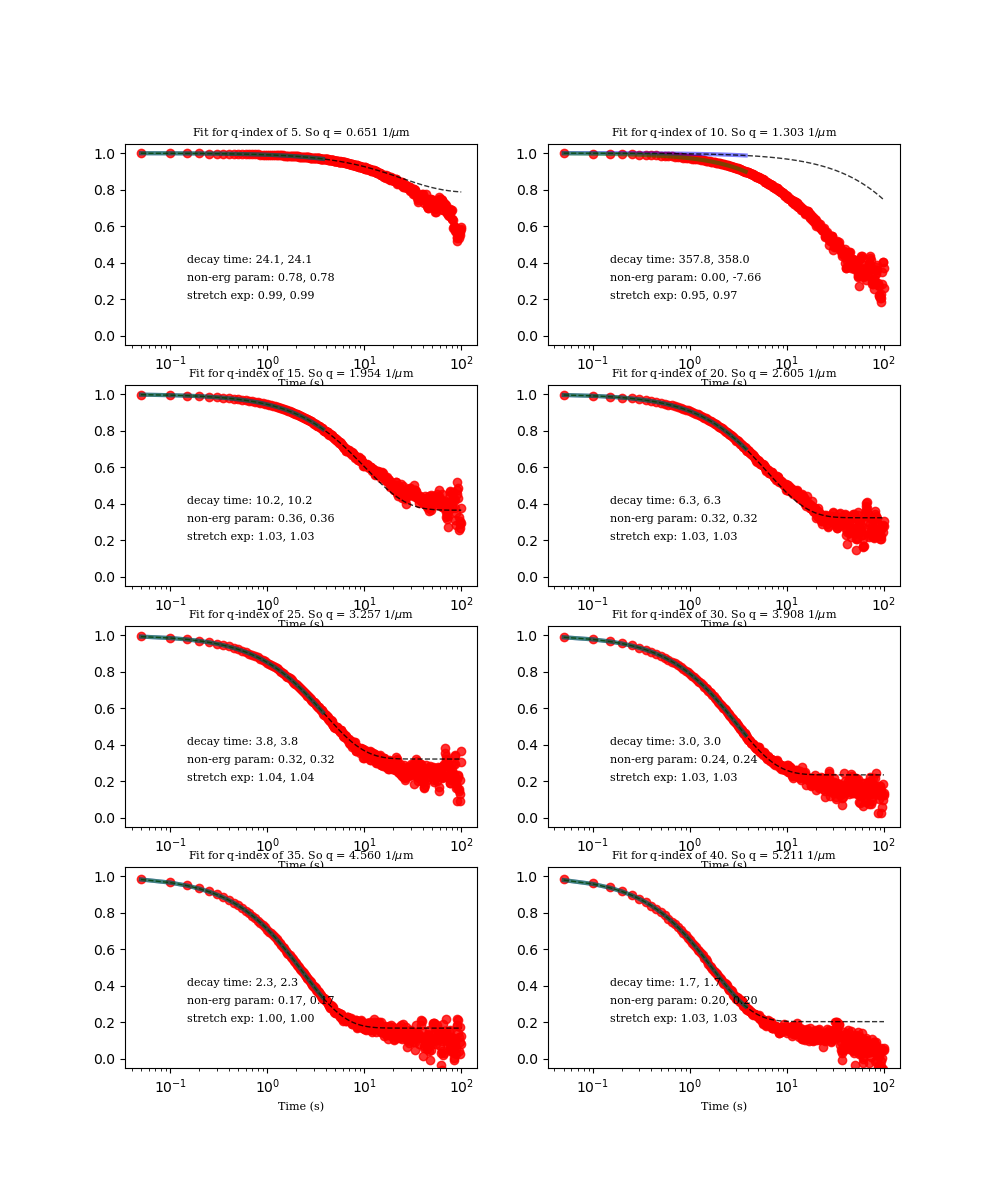

Saved as Y:\Pawan K\2021_DATA\DDM_and_PT_Olympus_2021_Jan_5\1\1_0_256x256_rav_ISF_fits_ExpoFit.png


In [30]:
#########################################################################
# We don't have to fit all time lags. The long time lags may be noisy.
#########################################################################
# not implemented anymore: last_time = -350 # ONLY FIT UP TO THIS FINAL TIME POINT

plt.figure(figsize=(10,12)) #Create figure of size 10x12

#########################################################################
# In making these plots, we'll not fix the stretching exponent.
# But feel free to change this.
#########################################################################
FIX_STRETCHING_EXP = False


#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([5,10,15,20,25,30,35,40]):
    
    #last_time = last_times[q_index]
    final_time = 75
    last_time = final_time
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,q_index],times[:last_time])
    full_time_theory = ddm.dTheoryNonErgISF(times, *fp_isf)

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times[:],isf[:,q_index],'ro',alpha=0.8)
    ax.plot(times[:last_time], theory_isf, '-b',lw=3,alpha=0.5) #BLUE LINE: Leven-Marq fitting method
    ax.plot(times, full_time_theory, '--k',lw=1,alpha=0.8) #BLUE LINE: Leven-Marq fitting method
    ax.plot(times[:last_time], theory_isf_lstsq,'-g',lw=3,alpha=0.5) #GREEN LINE: scipy.optimize's leastsquares function
    
    ax.text(0.15,0.4, "decay time: %.1f, %.1f" % (fp_isf[1], fp_isf_lstsq[1]), fontdict=font_plt_ax)
    ax.text(0.15,0.3, "non-erg param: %.2f, %.2f" % (fp_isf[0], fp_isf_lstsq[0]), fontdict=font_plt_ax)
    ax.text(0.15,0.2, "stretch exp: %.2f, %.2f" % (fp_isf[2], fp_isf_lstsq[2]), fontdict=font_plt_ax)
    
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    ax.set_ylim(-0.05,1.05)
    
plt.savefig(data_dir+data_file[:-19]+"_ISF_fits_ExpoFit.png",dpi=150)
print("Saved as %s" % data_dir+data_file[:-19]+"_ISF_fits_ExpoFit.png")

Hopefully, the above fits to the normalize image structure function look okay. If not, you can try adjusting the `last_times` parameter. Sometimes, removing more of the last few time points from the data we fit to helps since the data associated with very long time lags tends to be noisier. 

Below, we do the fits for each wave vector (each q). We do this twice. One with fixing the stretching exponent and one time with letting it vary. When you see the results after the following code block, you'll choose the value for this stretching exponent and insert that value back into the block of code where the function `isf_fitting` was defined above. 

In [32]:
#Now, we'll do that fit for *all* q-values
start=timer()

FIX_STRETCHING_EXP = True
#Initialize arrays to store the fit paramters
tau_v2 = np.zeros_like(ravs[0,:]) #decay time
c = np.zeros_like(tau_v2) #this is the non-ergodicity parameter
alph_v2 = np.zeros_like(tau_v2) #alpha (stretching exponent)
for i in range(1,len(tau_v2)):
    last_time = final_time
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,i],times[:last_time])
    c[i] = fp_isf[0]
    tau_v2[i] = fp_isf[1]
    alph_v2[i] = fp_isf[2]

    
FIX_STRETCHING_EXP = False
#Initialize arrays to store the fit paramters -- THIS TIME FIXING ALPHA
tau_v2_varyalpha = np.zeros_like(ravs[0,:]) #decay time
c_varyalpha = np.zeros_like(tau_v2) #this is the non-ergodicity parameter
alph_v2_varyalpha = np.zeros_like(tau_v2) #alpha (stretching exponent)
for i in range(1,len(tau_v2_varyalpha)):
    last_time = final_time
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,i],times[:last_time])
    c_varyalpha[i] = fp_isf[0]
    tau_v2_varyalpha[i] = fp_isf[1]
    alph_v2_varyalpha[i] = fp_isf[2]

end=timer()
print ('seconds elapsed: %.2f' %(end-start))

C:\Users\research\anaconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


seconds elapsed: 4.97


<IPython.core.display.Javascript object>


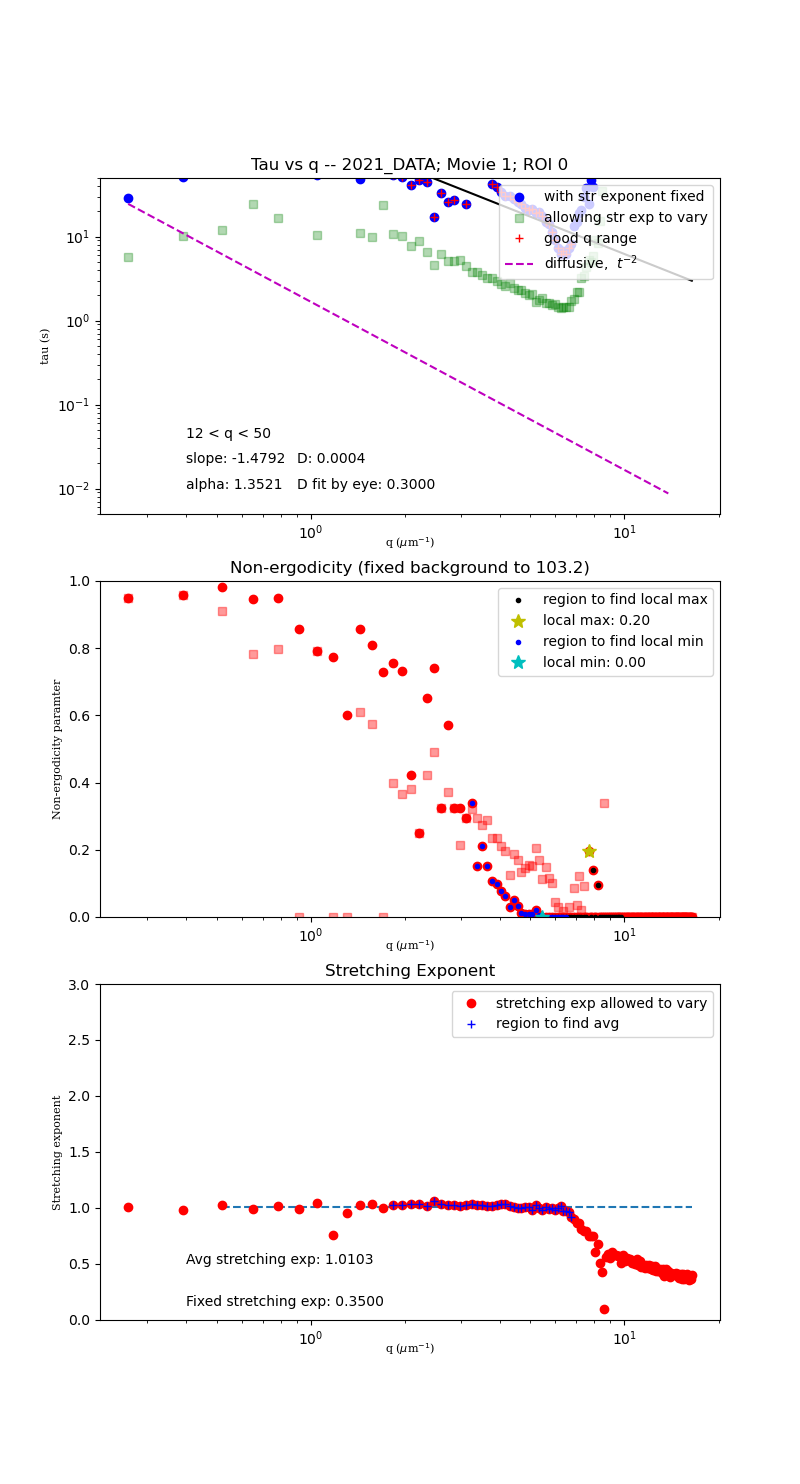

In [39]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,3*8/1.618)); ax = fig.gca();
ax = plt.subplot(3,1,1)

plt.title("Tau vs q -- " + data_dir.split('\\')[-4] + "; Movie " + str(movie_num) + "; ROI " + str(ROI))
qs=q[2:-1]
new_taus=ddm.newt(tau_v2[2:-1],alph_v2[2:-1])
new_taus_varyalpha=ddm.newt(tau_v2_varyalpha[2:-1],alph_v2_varyalpha[2:-1])
#ax.loglog(qs, tau_v2[2:-1],'gs',alpha=0.2) 
ax.loglog(qs, new_taus,'bo', label='with str exponent fixed')
ax.loglog(qs, new_taus_varyalpha,'gs',alpha=0.3, label='allowing str exp to vary')

#############################################################################
# Pick the range of q-value that seem to fit best (usually ~25ish to ~42ish)
#############################################################################
minq=12
maxq=50

#######################################
#  You can comment out a large block  #
#  by highlighting it and using three #
#  quotation marks '''                #
#######################################

#############################################################################
##################### Fit with alpha fixed!!!!!!! ###########################
#############################################################################
qmin=qs[minq]
qmax=qs[maxq]
b = np.where((qs>=qmin)&(qs<=qmax))
ax.plot(qs[b[0]],new_taus[b[0]],'r+',label='good q range')
a = np.polyfit(np.log(qs[b[0]]),np.log(new_taus[b[0]]), 1)
slope = a[0]
coef1 = np.exp(a[1])
alpha = 2./(-1*slope)
Dif = (1.0/coef1)**alpha
tau_fit = coef1*(qs**(-2.0/alpha))
ax.plot(qs, tau_fit, '-k')

#############################################################################
##################### Fit with alpha varied!!!!!!! ###########################
#############################################################################
'''qmin=qs[minq]
qmax=qs[maxq]
b = np.where((qs>=qmin)&(qs<=qmax))
ax.plot(qs[b[0]],new_taus_varyalpha[b[0]],'r+',label='good q range')
a = np.polyfit(np.log(qs[b[0]]),np.log(new_taus_varyalpha[b[0]]), 1)
slope = a[0]
coef1 = np.exp(a[1])
alpha = 2./(-1*slope)
Dif = (1.0/coef1)**alpha
tau_fit = coef1*(qs**(-2.0/alpha))
ax.plot(qs, tau_fit, '-k')'''

## does it fit ballistically?
fix_speed = 0.60
fix_slope = 2.
ax.plot(qs[:-20], (1./fix_speed) * (1./(qs[:-20]**(fix_slope))), '--m', label="diffusive, $\ t$$^{-2}$")

ax.text(0.4,1*.01, "alpha: %.4f" % alpha)
ax.text(.9,2*.01, "D: %.4f" % (Dif/2.))
ax.text(0.4,4*.01, "%i < q < %i" % (minq, maxq))
ax.text(0.4,2*.01, "slope: %.4f" % (slope))

ax.text(.9,1*.01, "D fit by eye: %.4f" % (fix_speed/2.))
        
        
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.set_ylim(.005,50)
ax.legend(loc=1)


#Plot the non-erg parameter versus the wave vector
ax = plt.subplot(3,1,2)
plt.title("Non-ergodicity (fixed background to %.1f)" % background)
ax.semilogx(q[2:-1], c[2:-1], 'ro')
ax.semilogx(q[2:-1], c_varyalpha[2:-1], 'rs', alpha=0.4)
c_range = np.where((qs>=q[45])&(qs<=q[75]))
ax.semilogx(qs[c_range], c[2:-1][c_range], 'k.',label='region to find local max')
c_local_max = c[2:-1][c_range].max()
where_local_max = np.argmax(c[2:-1][c_range])
ax.semilogx(qs[c_range][where_local_max], c_local_max, '*', c='y', ms=10, label='local max: %.2f' % c_local_max)
c_range = np.where((qs>=q[25])&(qs<=q[50]))
ax.semilogx(qs[c_range], c[2:-1][c_range], 'b.',label='region to find local min')
c_local_min = c[2:-1][c_range].min()
where_local_min = np.argmin(c[2:-1][c_range])
ax.semilogx(qs[c_range][where_local_min], c_local_min, '*', c='c', ms=10, label='local min: %.2f' % c_local_min)
ax.set_ylim(0,1)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Non-ergodicity paramter", fontdict=font_plt_ax)
ax.legend(loc=0)

#Plot the stretching exponent versus the wave vector
ax = plt.subplot(3,1,3)
plt.title("Stretching Exponent")
ax.semilogx(q[2:-1], alph_v2_varyalpha[2:-1], 'ro',label='stretching exp allowed to vary')
#ax.semilogx(q[3:-1], alph_v2[2:-1], 'rs')
ax.plot(qs[b[0]],alph_v2_varyalpha[2:-1][b[0]],'b+',label='region to find avg')
ax.hlines(alph_v2_varyalpha[2:-1][b[0]].mean(), qs[2],qs[-1], linestyles='dashed')
ax.text(0.4,0.5,"Avg stretching exp: %.4f" % alph_v2_varyalpha[2:-1][b[0]].mean())
ax.text(0.4,0.12,"Fixed stretching exp: %.4f" % alph_v2[2])
ax.set_ylim(0,3)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Stretching exponent", fontdict=font_plt_ax)
ax.legend(loc=0)

#Save this figure at a PNG file.
plt.savefig(data_dir+data_file[:-18]+"_tauvsq_nonergparam_ExpoFit.png",dpi=150)
#print("Saved to %s" % data_dir+data_file[:-23]+"_tauvsq_nonergparam_ExpoFit.png")

## IMPORTANT!

After looking at the plots above, figure out a good value for the stretching exponent (what we call 'alpha' in the code). It should be the average stretching exponent over a range of q values. The range of q values in use is indicated with the red or blue crosses on the plot of the decay time vs q and stretching exponent vs q. If that range seems inappropriate, change the `minq` and `maxq` paratmers.

Once you've found that, go back to the fitting function -- the `isf_fitting` function -- was defined, and find the first line of that block of code: <br />
`STRETCHING_EXP = 0.6`. <br />
(Or, it might not say '0.6' but some other number.) <br />
Change that value from whatever is to the new value (probably something between 0.5 and 0.8 though it could range anywhere between 0 and 1) and you only need to go to the hundredths place -- no need to go to further decimal places.

In [41]:
fitting_parameters = {} #initialize empty dictionary
fitting_parameters['last_times'] = last_times
fitting_parameters['qs'] = q
fitting_parameters['q_used'] = [minq,maxq]
fitting_parameters['c'] = c
fitting_parameters['c_varyalpha'] = c_varyalpha
fitting_parameters['c_localmax'] = c_local_max
#fitting_parameters['c_localmin'] = c_local_min
fitting_parameters['tau'] = tau_v2
fitting_parameters['tau_varyalpha'] = tau_v2_varyalpha
fitting_parameters['stretching_exponent'] = alph_v2_varyalpha
fitting_parameters['stretching_exponent_fixed'] = alph_v2[2]
fitting_parameters['k'] = Dif
fitting_parameters['alpha'] = alpha
fitting_parameters['fps'] = fps
fitting_parameters['pixel_size'] = pixel_size
fitting_parameters['data_directory'] = data_dir
fitting_parameters['Movie'] = movie_num
fitting_parameters['ROI'] = ROI
fitting_parameters['ISF'] = isf
fitting_parameters['ISF_theory'] = theory_isf
fitting_parameters['chi'] = chi2
fitting_parameters['times'] = times
fitting_parameters['background'] = background
fitting_parameters['ravs'] = ravs

data_file_p = data_file[:-18]+"_NormalizedISFFitting_ExpoFit.p"
f = open(data_dir + data_file_p,'wb')
pickle.dump(fitting_parameters, f)
f.close()

In [42]:
qindex=[10,15,20,25,30]
ten = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[0]],fitting_parameters['tau'][qindex[0]],
                           fitting_parameters['stretching_exponent'][qindex[0]])
fifteen = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[1]],fitting_parameters['tau'][qindex[1]],
                           fitting_parameters['stretching_exponent'][qindex[1]])
twenty = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[2]],fitting_parameters['tau'][qindex[2]],
                           fitting_parameters['stretching_exponent'][qindex[2]])
twentyfive = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[3]],fitting_parameters['tau'][qindex[3]],
                           fitting_parameters['stretching_exponent'][qindex[3]])
thirty = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[4]],fitting_parameters['tau'][qindex[4]],
                           fitting_parameters['stretching_exponent'][qindex[4]])

In [48]:
data_file_p = data_file[:-18]+"_ISFs.csv"
f = open(data_dir+data_file_p,'w')
filewriter = csv.writer(f, delimiter=',')
filewriter.writerow(['time','q10','q10fit','q15','q15fit','q20','q20fit','q25','q25fit','q30','q30fit'])
for i in range(len(fitting_parameters['ISF'][:,0])):
    filewriter.writerow([times[i], fitting_parameters['ISF'][i,qindex[0]], ten[i],
                         fitting_parameters['ISF'][i,qindex[1]], fifteen[i],
                         fitting_parameters['ISF'][i,qindex[2]], twenty[i],
                         fitting_parameters['ISF'][i,qindex[3]], twentyfive[i],
                         fitting_parameters['ISF'][i,qindex[4]], thirty[i]])
f.close()

data_file_t = data_file[:-18]+"_tau_v_q.csv"
f = open(data_dir+data_file_t,'w')
filewriter = csv.writer(f, delimiter=',')
filewriter.writerow(['qs','new_tau'])
for i in range(len(qs)):
    filewriter.writerow([qs[i], new_taus[i]])
f.close()

In [501]:
print q[10]
print q[15]
print q[20]

1.2651387941324874
1.897708191198731
2.530277588264975


In [50]:
#write some data to more readable file
csv_data_file = condition+"_"+date+"_%i_ROI_%i_256x256_parameters_ExpoFit.csv" % (movie_num, ROI)
f = open(data_dir + csv_data_file,'w')
filewriter = csv.writer(f, delimiter=',')
filewriter.writerow([data_dir])
filewriter.writerow(['Movie','ROI','k','alpha','slope','speed','avg stretching exp','non-erq at q=2.457'])
filewriter.writerow([str(movie_num), str(ROI), "%.4f" % Dif, "%.4f" % alpha, "%.4f" % slope, "%.4f" % fix_speed, 
                     "%.4f" % alph_v2[2:-1][b[0]].mean(), 
                    "%.4f" % c[35]])
f.close()

print("Saving to a csv file that you can open with Excel: \n")
print("  k: %.4f \n  alpha: %.4f \n  stretch. exp.: %.4f \n  c[35]: %.4f" % (Dif, alpha, alph_v2[2:-1][b[0]].mean(), c[35]))

Saving to a csv file that you can open with Excel: 

  k: 0.0008 
  alpha: 1.3521 
  stretch. exp.: 0.3500 
  c[35]: 0.0328


# At this point, run a new movie or ROI. If you're finished, copy the data from that excel file to the google doc!!!!

## After analyzing all four ROIs of a movie, combine data.

In [ ]:
## If you want to combine these files from some other data directory, you can edit data_dir. Otherwise don't.
print("Current 'data_dir' is %s" % data_dir)

In [ ]:
#changing data_dir
#data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\20_1_14_CoXL\\analysis\\"

In [ ]:
csv_files = glob.glob(data_dir + "*_%i_ROI*.csv" % movie_num)

csv_all_data_file = condition+"_%i_all_256x256_parameters.csv" % movie_num
f_all = open(data_dir + csv_all_data_file,'wb')
filewriter = csv.writer(f_all, delimiter=',')
f_all_header_not_written_yet = True

for i,filename in enumerate(csv_files):
    if not "_all_" in filename:
        f = open(filename,'r')
        filereader = csv.reader(f, delimiter=',')
        for j,row in enumerate(filereader):
            if f_all_header_not_written_yet:
                filewriter.writerow(row)
            else:
                if j>1:
                    filewriter.writerow(row)
        f_all_header_not_written_yet = False
        f.close()
f_all.close()